Device: cuda
Training simple RNN...
Epoch 001  Train MSE: 0.351167  Val MSE: 0.181337
Epoch 005  Train MSE: 0.166013  Val MSE: 0.180613
Epoch 010  Train MSE: 0.167345  Val MSE: 0.179723
Epoch 015  Train MSE: 0.165987  Val MSE: 0.181744
Epoch 020  Train MSE: 0.165816  Val MSE: 0.179791
Epoch 025  Train MSE: 0.168748  Val MSE: 0.179433
Epoch 030  Train MSE: 0.166366  Val MSE: 0.183597
Epoch 035  Train MSE: 0.165827  Val MSE: 0.182941
Epoch 040  Train MSE: 0.166796  Val MSE: 0.178408
Epoch 045  Train MSE: 0.165479  Val MSE: 0.178919
Epoch 050  Train MSE: 0.165645  Val MSE: 0.178357
Epoch 055  Train MSE: 0.167151  Val MSE: 0.179062
Epoch 060  Train MSE: 0.166075  Val MSE: 0.178550

Training LSTM...
Epoch 001  Train MSE: 0.282995  Val MSE: 0.183392
Epoch 005  Train MSE: 0.166727  Val MSE: 0.184554
Epoch 010  Train MSE: 0.167880  Val MSE: 0.178744
Epoch 015  Train MSE: 0.166740  Val MSE: 0.180131
Epoch 020  Train MSE: 0.166690  Val MSE: 0.179359
Epoch 025  Train MSE: 0.167923  Val MSE: 0.178

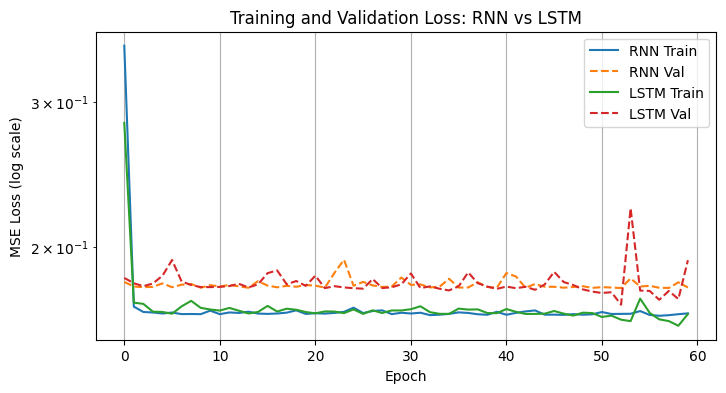

RNN predictions scatter:


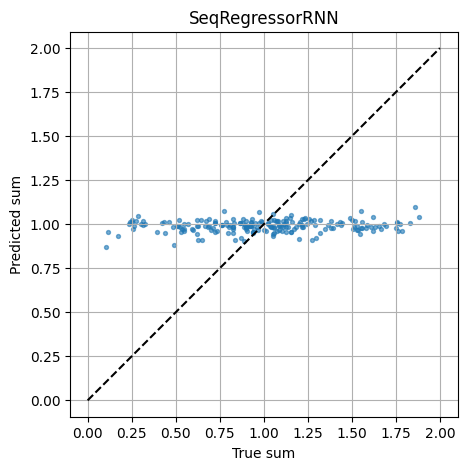

LSTM predictions scatter:


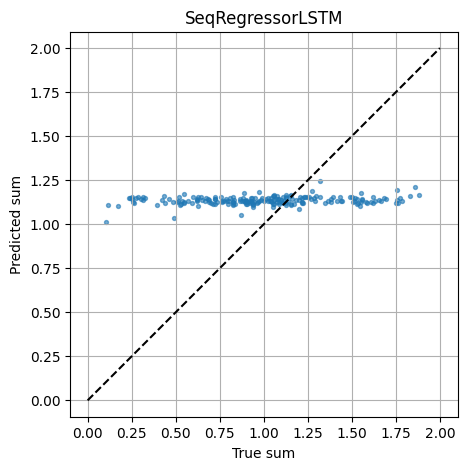

In [ ]:
# 必要ライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# デバイス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ======== データ生成：Adding Problem ========
# 入力: 長さ T の系列、各ステップは (value, marker)
# - value: U(0,1)
# - marker: 0, ただしランダムに2箇所だけ1になる
# 目的: marker==1 のときの value を足したスカラーを予測

def generate_adding_dataset(n_samples, seq_len=100):
    X = np.random.rand(n_samples, seq_len).astype(np.float32)  # values
    markers = np.zeros((n_samples, seq_len), dtype=np.float32)
    targets = np.zeros((n_samples,), dtype=np.float32)
    for i in range(n_samples):
        idx = np.random.choice(seq_len, size=2, replace=False)
        markers[i, idx] = 1.0
        targets[i] = X[i, idx].sum()
    # combine channels: shape (n, seq_len, 2)
    inputs = np.stack([X, markers], axis=-1)
    return torch.tensor(inputs), torch.tensor(targets).unsqueeze(1)  # target shape (n,1)

# ハイパーパラメータ
SEQ_LEN = 100
N_TRAIN = 4000
N_VAL = 1000
BATCH = 128
EPOCHS = 60
LR = 0.001
HIDDEN = 128

X_train, y_train = generate_adding_dataset(N_TRAIN, seq_len=SEQ_LEN)
X_val, y_val = generate_adding_dataset(N_VAL, seq_len=SEQ_LEN)

train_ds = torch.utils.data.TensorDataset(X_train, y_train)
val_ds = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH)

# ======== モデル定義: SimpleRNN と LSTM を比較 ========
class SeqRegressorRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=HIDDEN, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, nonlinearity='tanh')
        self.head = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: (batch, seq_len, 2)
        out, hn = self.rnn(x)  # out: (b, seq_len, hidden)
        last = out[:, -1, :]   # 末尾タイムステップの出力
        return self.head(last)

class SeqRegressorLSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.2,
            batch_first=True
        )
        self.layernorm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layernorm(out)
        y = self.fc(out[:, -1, :])  # 全系列を通した最終ステップ

        return y


# ======== トレーニング関数 ========
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        with torch.no_grad():
            running = 0.0
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                running += loss.item() * xb.size(0)
            val_loss = running / len(val_loader.dataset)
            val_losses.append(val_loss)

        if epoch % 5 == 0 or epoch==1:
            print(f"Epoch {epoch:03d}  Train MSE: {train_loss:.6f}  Val MSE: {val_loss:.6f}")
    return model, train_losses, val_losses

# ======== 実験: RNN vs LSTM ========
rnn_model = SeqRegressorRNN()
lstm_model = SeqRegressorLSTM()

print("Training simple RNN...")
rnn_trained, rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader)

print("\nTraining LSTM...")
lstm_trained, lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader)

# ======== 可視化: ロス推移 ========
plt.figure(figsize=(8,4))
plt.plot(rnn_train_losses, label="RNN Train")
plt.plot(rnn_val_losses, '--', label="RNN Val")
plt.plot(lstm_train_losses, label="LSTM Train")
plt.plot(lstm_val_losses, '--', label="LSTM Val")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.legend()
plt.title("Training and Validation Loss: RNN vs LSTM")
plt.grid(True)
plt.show()

# ======== 可視化: 予測精度（散布図） ========
def eval_scatter(model, X, y, n_points=200):
    model.eval()
    with torch.no_grad():
        inp = X[:n_points].to(device)
        pred = model(inp).cpu().numpy().ravel()
    target = y[:n_points].numpy().ravel()
    plt.figure(figsize=(5,5))
    plt.scatter(target, pred, s=8, alpha=0.6)
    plt.plot([0,2],[0,2], 'k--')  # 理想線 y=x
    plt.xlabel("True sum")
    plt.ylabel("Predicted sum")
    plt.title(type(model).__name__)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

print("RNN predictions scatter:")
eval_scatter(rnn_trained, X_val, y_val)
print("LSTM predictions scatter:")
eval_scatter(lstm_trained, X_val, y_val)


One example RNN:


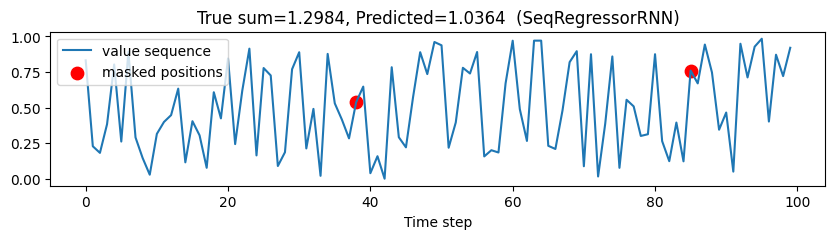

One example LSTM:


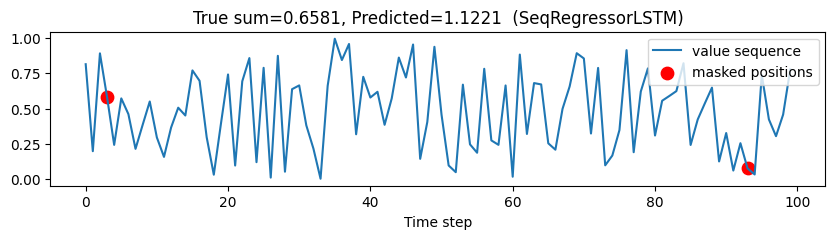

In [ ]:

# ======== 可視化: 例を取って系列内部を表示（どの位置を参照しているか） ========
def show_example_prediction(model, seq_len=SEQ_LEN):
    model.eval()
    Xs, ys = generate_adding_dataset(1, seq_len=seq_len)
    Xs_t = Xs.to(device)
    with torch.no_grad():
        pred = model(Xs_t).cpu().numpy().ravel()[0]
    values = Xs[0,:,0].numpy()
    markers = Xs[0,:,1].numpy().astype(int)
    true_sum = ys.item()
    plt.figure(figsize=(10,2))
    plt.plot(values, label='value sequence')
    plt.scatter(np.where(markers==1)[0], values[markers==1], color='red', s=80, label='masked positions')
    plt.title(f"True sum={true_sum:.4f}, Predicted={pred:.4f}  ({type(model).__name__})")
    plt.xlabel("Time step")
    plt.legend()
    plt.show()

print("One example RNN:")
show_example_prediction(rnn_trained)
print("One example LSTM:")
show_example_prediction(lstm_trained)

Epoch 1/20  Loss: 0.01912
Epoch 2/20  Loss: 0.02446
Epoch 3/20  Loss: 0.02238
Epoch 4/20  Loss: 0.00851
Epoch 5/20  Loss: 0.01655
Epoch 6/20  Loss: 0.00612
Epoch 7/20  Loss: 0.01667
Epoch 8/20  Loss: 0.00674
Epoch 9/20  Loss: 0.00184
Epoch 10/20  Loss: 0.00748
Epoch 11/20  Loss: 0.00763
Epoch 12/20  Loss: 0.01121
Epoch 13/20  Loss: 0.03417
Epoch 14/20  Loss: 0.01160
Epoch 15/20  Loss: 0.04177
Epoch 16/20  Loss: 0.01032
Epoch 17/20  Loss: 0.01224
Epoch 18/20  Loss: 0.00398
Epoch 19/20  Loss: 0.00738
Epoch 20/20  Loss: 0.01223


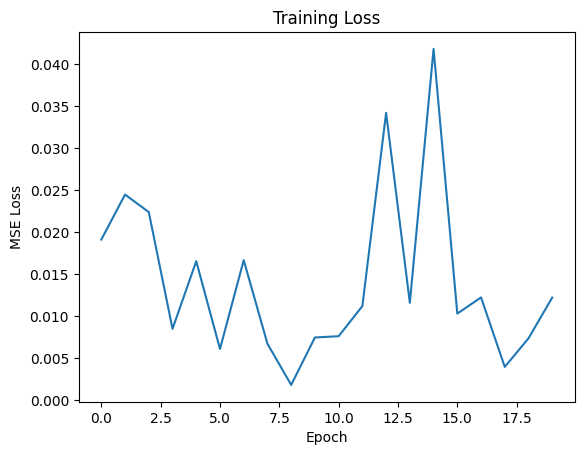

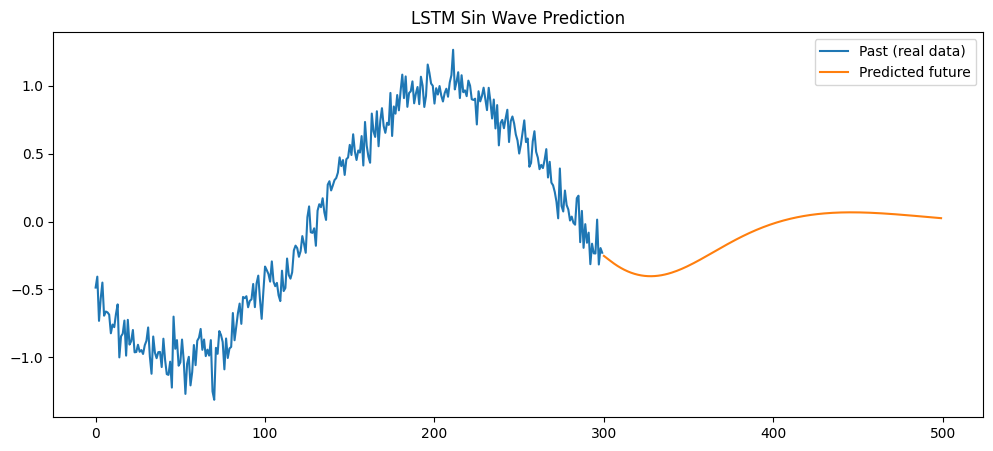

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# ================================================
# 1. 正弦波データを生成
# ================================================
def generate_sin_wave(seq_length=3000):
    x = np.arange(seq_length)
    y = np.sin(0.02 * x) + 0.1*np.random.randn(seq_length)  # ノイズあり sin 波
    return y


data = generate_sin_wave()


# ================================================
# 2. Dataset の作成（過去 50 ステップ → 次の 1 ステップ予測）
# ================================================
class SinDataset(Dataset):
    def __init__(self, data, input_len=50):
        self.data = data
        self.input_len = input_len

    def __len__(self):
        return len(self.data) - self.input_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_len]
        y = self.data[idx + self.input_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

input_len = 50
dataset = SinDataset(data, input_len)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


# ================================================
# 3. LSTM モデル定義
# ================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 最後のステップだけ使用
        return out


model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# ================================================
# 4. 学習ループ
# ================================================
loss_list = []

for epoch in range(20):
    for x, y in loader:
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)

        pred = model(x)
        loss = criterion(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())
    print(f"Epoch {epoch+1}/20  Loss: {loss.item():.5f}")


# --------------------------------------------
# 学習曲線の表示
# --------------------------------------------
plt.plot(loss_list)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()


# ================================================
# 5. 未来の波形を LSTM に予測させる
# ================================================
model.eval()

input_seq = torch.tensor(data[-input_len:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
predicted = []

for _ in range(200):  # 200 ステップ未来を予測
    with torch.no_grad():
        next_val = model(input_seq).item()
    predicted.append(next_val)

    # 入力シーケンスを更新（古い値を削除し、予測値を追加）
    input_seq = torch.cat(
        [input_seq[:, 1:, :], torch.tensor([[[next_val]]], dtype=torch.float32)],
        dim=1
    )


# ================================================
# 6. 結果の可視化
# ================================================
plt.figure(figsize=(12, 5))
plt.plot(data[-300:], label="Past (real data)")
plt.plot(range(300, 300+200), predicted, label="Predicted future")
plt.legend()
plt.title("LSTM Sin Wave Prediction")
plt.show()


==== RNN 学習 ====
Epoch 10/50, Train Loss: 0.0768, Test Loss: 0.0688
Epoch 20/50, Train Loss: 0.0212, Test Loss: 0.0149
Epoch 30/50, Train Loss: 0.0099, Test Loss: 0.0102
Epoch 40/50, Train Loss: 0.0048, Test Loss: 0.0065
Epoch 50/50, Train Loss: 0.0040, Test Loss: 0.0041

==== LSTM 学習 ====
Epoch 10/50, Train Loss: 0.0664, Test Loss: 0.0696
Epoch 20/50, Train Loss: 0.0559, Test Loss: 0.0558
Epoch 30/50, Train Loss: 0.0522, Test Loss: 0.0522
Epoch 40/50, Train Loss: 0.0505, Test Loss: 0.0500
Epoch 50/50, Train Loss: 0.0495, Test Loss: 0.0490


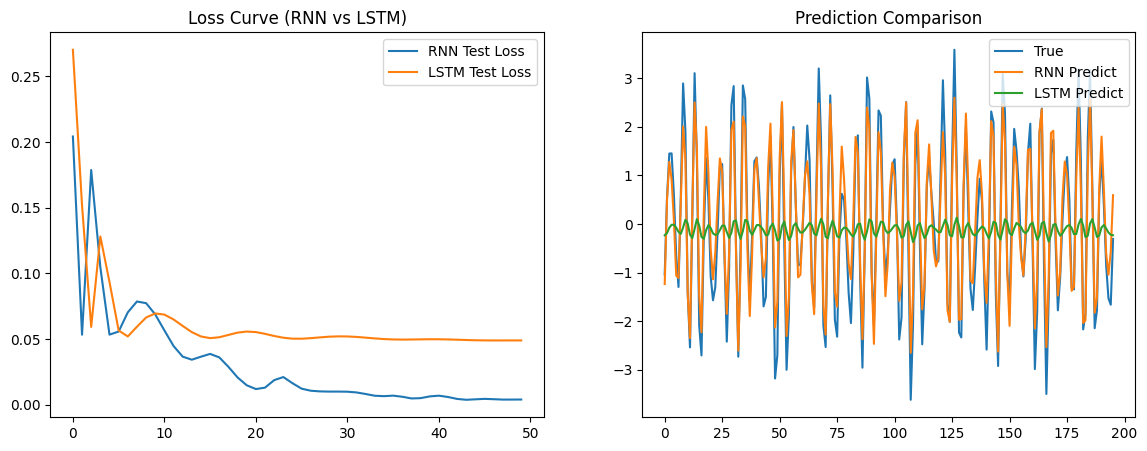

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------------------------
# データ生成：正弦波
# ---------------------------------------------------------
np.random.seed(0)
t = np.linspace(0, 500, 1000)
y = np.sin(3*t) + 2.1 * np.sin(40*t) + 0.5 * np.sin(100*t) + 0.1 * np.random.randn(len(t))   # ノイズ付き

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1))

# 時系列データ作成
def create_dataset(data, time_steps=20):
    X, Y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        Y.append(data[i+time_steps])
    return np.array(X), np.array(Y)

time_steps = 20
X, Y = create_dataset(y_scaled, time_steps)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
Y_train, Y_test = Y_tensor[:train_size], Y_tensor[train_size:]

# ---------------------------------------------------------
# モデル定義（RNN / LSTM）
# ---------------------------------------------------------
class RNNModel(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


class LSTMModel(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# ---------------------------------------------------------
# 学習関数
# ---------------------------------------------------------
def train_model(model, X_train, Y_train, X_test, Y_test, epochs=50):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        test_out = model(X_test)
        test_loss = criterion(test_out, Y_test).item()

        train_losses.append(loss.item())
        test_losses.append(test_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses


# ---------------------------------------------------------
# モデル作成 & 学習
# ---------------------------------------------------------
rnn = RNNModel()
lstm = LSTMModel()

print("==== RNN 学習 ====")
rnn_train_loss, rnn_test_loss = train_model(rnn, X_train, Y_train, X_test, Y_test)

print("\n==== LSTM 学習 ====")
lstm_train_loss, lstm_test_loss = train_model(lstm, X_train, Y_train, X_test, Y_test)


# ---------------------------------------------------------
# 予測
# ---------------------------------------------------------
rnn.eval()
lstm.eval()

rnn_pred = rnn(X_test).detach().numpy()
lstm_pred = lstm(X_test).detach().numpy()

# 逆正規化
rnn_pred_inv = scaler.inverse_transform(rnn_pred)
lstm_pred_inv = scaler.inverse_transform(lstm_pred)
Y_test_inv = scaler.inverse_transform(Y_test.numpy())

# ---------------------------------------------------------
# 結果可視化
# ---------------------------------------------------------

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.title("Loss Curve (RNN vs LSTM)")
plt.plot(rnn_test_loss, label="RNN Test Loss")
plt.plot(lstm_test_loss, label="LSTM Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title("Prediction Comparison")
plt.plot(Y_test_inv, label="True")
plt.plot(rnn_pred_inv, label="RNN Predict")
plt.plot(lstm_pred_inv, label="LSTM Predict")
plt.legend()

plt.show()


Epoch 10, Train Loss: 0.069207, Test Loss: 0.071016
Epoch 20, Train Loss: 0.060399, Test Loss: 0.059003
Epoch 30, Train Loss: 0.053100, Test Loss: 0.051633
Epoch 40, Train Loss: 0.041877, Test Loss: 0.039505
Epoch 50, Train Loss: 0.021826, Test Loss: 0.021916
Epoch 60, Train Loss: 0.019013, Test Loss: 0.017954
Epoch 70, Train Loss: 0.016818, Test Loss: 0.016824
Epoch 80, Train Loss: 0.016723, Test Loss: 0.016760


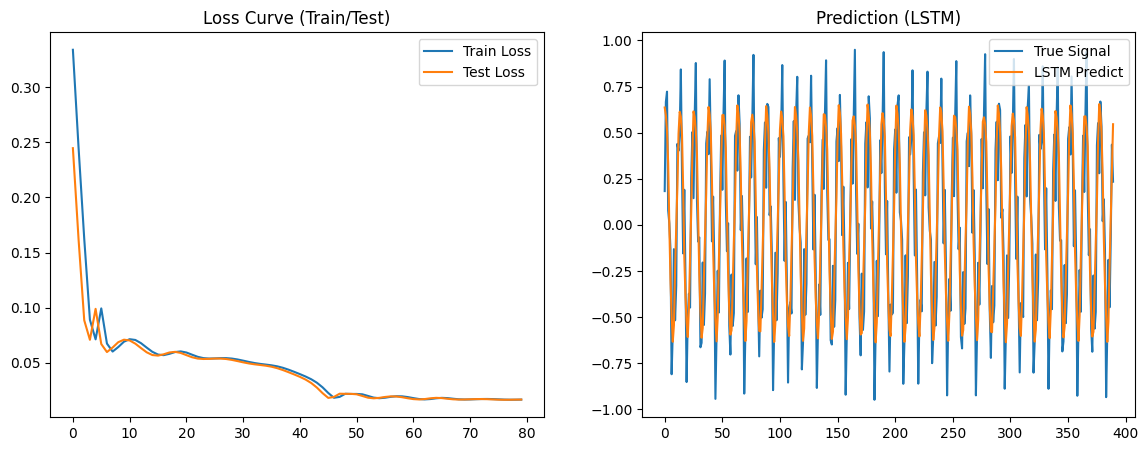

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------------------------
# データ生成：複合サイン波（LSTMが得意なパターン）
# ---------------------------------------------------------
np.random.seed(0)
t = np.linspace(0, 2000, 2000)

y = (
    0.6 * np.sin(0.5 * t) +   # 長周期
    0.3 * np.sin(2.0 * t) +   # 中周期
    0.1 * np.sin(5.0 * t)     # 短周期
)

# ノイズは少なめに
y += 0.02 * np.random.randn(len(y))

# スケール変換
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1))


# ---------------------------------------------------------
# 時系列データ作成用関数
# ---------------------------------------------------------
def create_dataset(data, time_steps=50):
    X, Y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        Y.append(data[i+time_steps])
    return np.array(X), np.array(Y)


# 時系列を作成
time_steps = 50
X, Y = create_dataset(y_scaled, time_steps)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# 80% を学習
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
Y_train, Y_test = Y_tensor[:train_size], Y_tensor[train_size:]


# ---------------------------------------------------------
# LSTM モデル
# ---------------------------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


# モデル生成
model = LSTMModel(hidden_size=64)

# ---------------------------------------------------------
# 학습 설정
# ---------------------------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_losses = []
test_losses = []

# ---------------------------------------------------------
# 学習ループ
# ---------------------------------------------------------
epochs = 80

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()

    # テスト
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, Y_test).item()

    train_losses.append(loss.item())
    test_losses.append(test_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.6f}, Test Loss: {test_loss:.6f}")


# ---------------------------------------------------------
# 推論
# ---------------------------------------------------------
model.eval()
with torch.no_grad():
    pred = model(X_test).numpy()

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(Y_test.numpy())


# ---------------------------------------------------------
# 可視化
# ---------------------------------------------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.title("Loss Curve (Train/Test)")
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title("Prediction (LSTM)")
plt.plot(true_inv, label="True Signal")
plt.plot(pred_inv, label="LSTM Predict")
plt.legend()

plt.show()


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

########################################
# 文章の長さを変化させる変数
########################################
length_sentence = 70

# reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

########################################
# 1. データ生成（if ... then ...）
########################################

conditions = ["sports", "politics", "food"]
sentiments = {
    "sports": 0,    # positive などにしてもよい
    "politics": 1,
    "food": 2
}

# 中間に関係ない単語を多数挿入して"距離"を伸ばす
filler_words = ["the", "a", "man", "woman", "today", "read", "blue", "green"]

def generate_sentence():
    cond = random.choice(conditions)
    label = sentiments[cond]

    fillers = [random.choice(filler_words) for _ in range(length_sentence)]  # 長距離依存を生む
    sentence = ["if", cond] + fillers + ["then", "TARGET"]
    return sentence, label

# データセット
class NLPDataset(Dataset):
    def __init__(self, n):
        self.data = [generate_sentence() for _ in range(n)]

        # 単語辞書
        vocab = set()
        for sent, _ in self.data:
            vocab.update(sent)
        self.word2id = {w: i+1 for i, w in enumerate(vocab)}
        self.word2id["<pad>"] = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        ids = [self.word2id[w] for w in sentence]
        return torch.tensor(ids), torch.tensor(label)

def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.tensor([x[1] for x in batch])

    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)
    padded = torch.zeros(len(sequences), max_len).long()

    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq
    return padded, labels

train_ds = NLPDataset(1500)
test_ds = NLPDataset(300)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn)

########################################
# 2. LSTM モデル
########################################

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, hidden_dim=64, num_classes=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embed(x)
        out, (h, c) = self.lstm(emb)
        return self.fc(h[-1])  # 最終の隠れ状態で分類

model = LSTMClassifier(len(train_ds.word2id), embed_dim=32, hidden_dim=64)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

########################################
# 3. 学習
########################################

def evaluate(loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += len(y)
    return correct / total

for epoch in range(10):
    model.train()
    for X, y in train_loader:
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

    acc = evaluate(test_loader)
    print(f"Epoch {epoch+1}, Test Accuracy: {acc:.3f}")





Epoch 1, Test Accuracy: 0.327
Epoch 2, Test Accuracy: 0.333
Epoch 3, Test Accuracy: 0.330
Epoch 4, Test Accuracy: 0.317
Epoch 5, Test Accuracy: 0.350
Epoch 6, Test Accuracy: 0.323
Epoch 7, Test Accuracy: 0.337
Epoch 8, Test Accuracy: 0.347
Epoch 9, Test Accuracy: 0.330
Epoch 10, Test Accuracy: 0.320


10: 1.0

20 : 0.703

30: 0.677

40: 0.337

50: 0.290

60: 0.293

70: 0.32

In [2]:
########################################
# 4. 予測例を可視化
########################################
def show_prediction():
    sent, lbl = generate_sentence()
    ids = torch.tensor([train_ds.word2id[w] for w in sent]).unsqueeze(0)
    pred = model(ids).argmax(dim=1).item()
    print("Sentence:", " ".join(sent))
    print("True label:", lbl)
    print("Pred label:", pred)

show_prediction()

Sentence: if sports green read woman read a read a blue a a woman a a read a blue man read woman woman then TARGET
True label: 0
Pred label: 0


In [3]:
def show_prediction():
    sent, lbl = generate_sentence()
    ids = torch.tensor([train_ds.word2id[w] for w in sent]).unsqueeze(0)
    pred = model(ids).argmax(dim=1).item()
    print("Sentence:", " ".join(sent))
    print("True label:", lbl)
    print("Pred label:", pred)

show_prediction()

Sentence: if food woman green today green today the today today green a green green today today today the blue blue man blue then TARGET
True label: 2
Pred label: 0


In [4]:
def show_prediction():
    sent, lbl = generate_sentence()
    ids = torch.tensor([train_ds.word2id[w] for w in sent]).unsqueeze(0)
    pred = model(ids).argmax(dim=1).item()
    print("Sentence:", " ".join(sent))
    print("True label:", lbl)
    print("Pred label:", pred)

show_prediction()

Sentence: if politics a read the woman the today blue today read green blue the blue blue man green woman a today today then TARGET
True label: 1
Pred label: 1


In [5]:
def show_prediction():
    sent, lbl = generate_sentence()
    ids = torch.tensor([train_ds.word2id[w] for w in sent]).unsqueeze(0)
    pred = model(ids).argmax(dim=1).item()
    print("Sentence:", " ".join(sent))
    print("True label:", lbl)
    print("Pred label:", pred)

show_prediction()

Sentence: if sports green blue today blue today green the a today man green a the woman today a green woman blue blue then TARGET
True label: 0
Pred label: 0


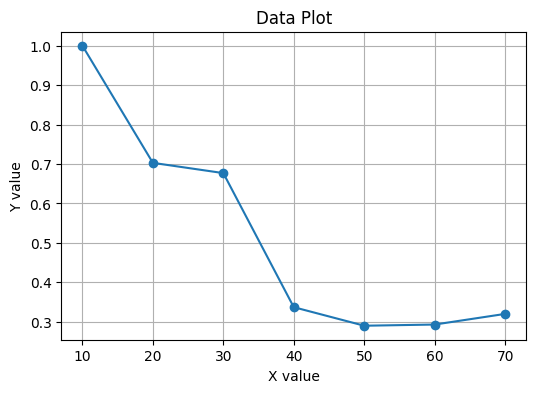

In [14]:
import matplotlib.pyplot as plt

# データ
x = [10, 20, 30, 40, 50, 60, 70]
y = [1.0, 0.703, 0.677, 0.337, 0.290, 0.293, 0.32]

# グラフ描画
plt.figure(figsize=(6,4))
plt.plot(x, y, marker='o')
plt.xlabel("X value")
plt.ylabel("Y value")
plt.title("Data Plot")
plt.grid(True)
plt.show()
